# Understanding Deepfakes with Keras

![DCGAN](DCGAN.png)

# Task 1: Importing Libraries and Helper Functions

Please note: If you haven't already, please install the required packages by executing the code cell below.

In [1]:
%matplotlib notebook

import tensorflow as tf
import numpy as np
import os
import tfutils

from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, Reshape, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from PIL import Image

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.1.0


# Task 2: Importing and Plotting the Data

In [2]:
#download mnist dataset and preprocess it to normalize it
(X_train, y_train), (X_test, y_test) = tfutils.datasets.mnist.load_data(one_hot=False)

In [4]:
#only use 0
X_train = tfutils.datasets.mnist.load_subset([0], X_train, y_train)
X_test = tfutils.datasets.mnist.load_subset([0], X_test, y_test)

In [5]:
#combine sets
X = np.concatenate([X_train, X_test], axis=0)

<IPython.core.display.Javascript object>


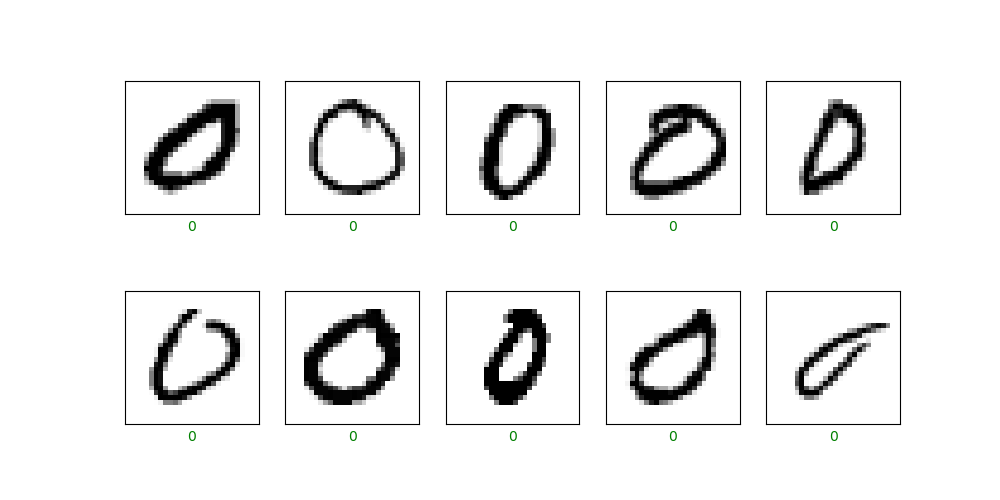

In [6]:
tfutils.datasets.mnist.plot_ten_random_examples(plt, X, np.zeros((X.shape[0], 1))).show()

# Task 3: Discriminator

![Artist and Critic](artist_critic.png)

In [9]:
#define model architect
discriminator = Sequential([
    
    Conv2D(64, 3, strides=2, input_shape=(28, 28, 1)),
    LeakyReLU(),
    BatchNormalization(),
    
    Conv2D(128, 5, strides=2),
    LeakyReLU(),
    BatchNormalization(),
    
    Conv2D(2564, 5, strides=2),
    LeakyReLU(),
    BatchNormalization(),
    
    Flatten(),
    Dense(1, activation='sigmoid')
    
])

In [11]:
#create an optimizer
opt = tf.keras.optimizers.Adam(lr=2e-4, beta_1=0.5)

In [12]:
#compile model
discriminator.compile(loss='binary_crossentropy',
                     optimizer=opt,
                     metrics=['accuracy'])

In [13]:
#model summary
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 13, 13, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 13, 13, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 13, 13, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 5, 5, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 5, 128)         512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 2564)        8

# Task 4: Generator

In [16]:
#generator is the artist
#we'll go in the opposite direction
generator = Sequential([
    
    Dense(256, activation='relu', input_shape=(1,)),
    Reshape((1, 1, 256)),
    
    Conv2DTranspose(256, 5, activation='relu'),
    BatchNormalization(),
    
    Conv2DTranspose(128, 5, activation='relu'),
    BatchNormalization(),
    
    Conv2DTranspose(64, 5, strides=2, activation='relu'),
    BatchNormalization(),
    
    Conv2DTranspose(32, 5, activation='relu'),
    BatchNormalization(),
    
    Conv2DTranspose(1, 4, activation='sigmoid')
    
])

In [17]:
#model summary
generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 256)               512       
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 1, 256)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 5, 5, 256)         1638656   
_________________________________________________________________
batch_normalization_7 (Batch (None, 5, 5, 256)         1024      
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 9, 9, 128)         819328    
_________________________________________________________________
batch_normalization_8 (Batch (None, 9, 9, 128)         512       
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 21, 21, 64)       

<IPython.core.display.Javascript object>


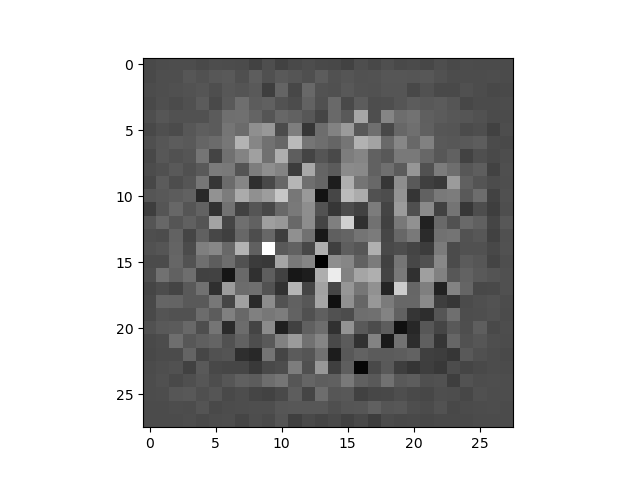

In [18]:
noise = np.random.randn(1, 1)
gen_image = generator.predict(noise)[0]

plt.figure()
plt.imshow(np.reshape(gen_image, (28, 28)), cmap='binary')
plt.show()

# Task 5: Generative Adversarial Network (GAN)

In [19]:
input_layer = tf.keras.layers.Input(shape=(1,))
gen_out = generator(input_layer)
disc_out = discriminator(gen_out)

gan = Model(input_layer, disc_out)

discriminator.trainable = False

In [20]:
#compile model
gan.compile(loss='binary_crossentropy', 
           optimizer=opt,
           metrics=['accuracy'])

#model summary
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 28, 28, 1)         2717025   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 8426521   
Total params: 11,143,546
Trainable params: 2,716,065
Non-trainable params: 8,427,481
_________________________________________________________________


# Tasks 6 and 7: Training the GAN

In [21]:
epochs = 25
batch_size = 128
steps_per_epoch = int(2 * X.shape[0]/batch_size)

print('Steps per epoch =', steps_per_epoch)

Steps per epoch = 107


<IPython.core.display.Javascript object>


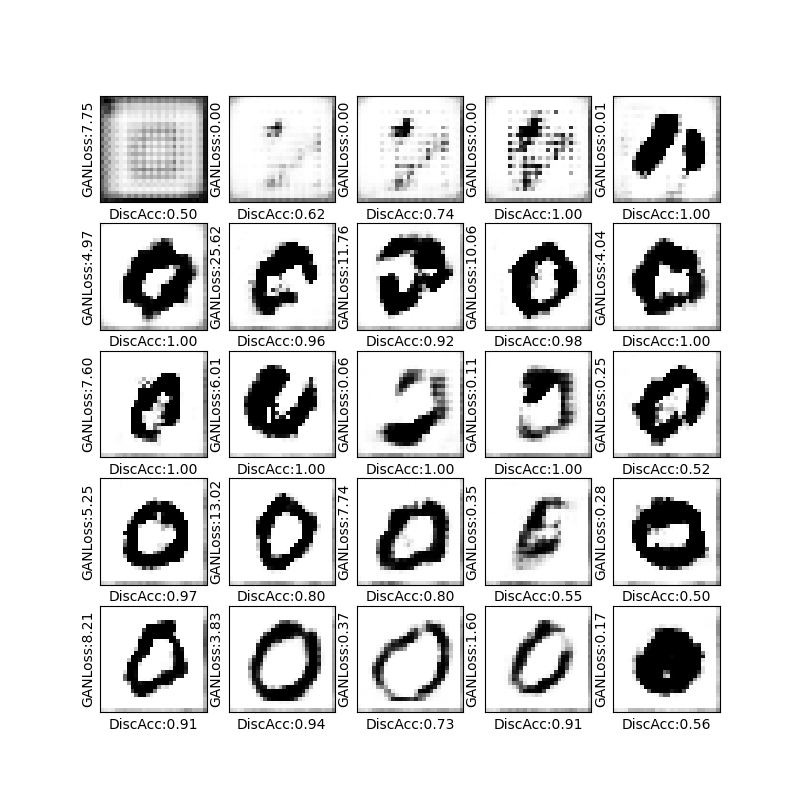

In [25]:
#dynamic plot
dp = tfutils.plotting.DynamicPlot(plt, 5, 5, (8, 8))

for e in range(0, epochs):
    dp.start_of_epoch(e)
    
    for step in range(0, steps_per_epoch):
        true_examples = X[int(batch_size/2)*step:int(batch_size/2)*(step+1)]
        true_examples = np.reshape(true_examples, (true_examples.shape[0], 28, 28, 1))
        
        noise = np.random.randn(int(batch_size/2), 1)
        gen_examples = generator.predict(noise)
        
        X_batch = np.concatenate([gen_examples, true_examples], axis=0)
        y_batch = np.array([0]*int(batch_size/2) + [1]*int(batch_size/2))
        
        indices = np.random.choice(range(batch_size), batch_size, replace=False)
        
        X_batch = X_batch[indices]
        y_batch = y_batch[indices]
        
        discriminator.trainable = True
        discriminator.train_on_batch(X_batch, y_batch)
        discriminator.trainable = False
        
        loss, _ = gan.train_on_batch(noise, np.ones((int(batch_size/2), 1)))
        _, acc = discriminator.evaluate(X_batch, y_batch, verbose=False)
        
    noise = np.random.randn(1, 1)
    gen_image = generator.predict(noise)[0]
    gen_image = np.reshape(gen_image, (28, 28))
    dp.end_of_epoch(gen_image, 'binary', 
                    'DiscAcc:{:.2f}'.format(acc),
                    'GANLoss:{:.2f}'.format(loss))